# Simultaneous Imitation (Scrap)

## Abstract

TODO


## Imitation Task
This is the video, subjects saw the video and imitated movements **simultaneously**.


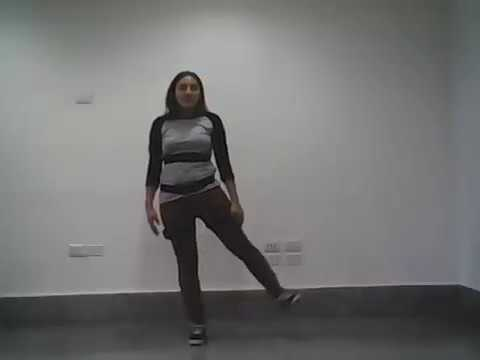

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('2hhV0Ev2PDQ')


## Subject heatmap and Grand Average

We calculate the grand average data heatmap and with only fixation, seems like data ranges are [0, 50] and [0, 30] for 
(x, y) respectively so we need to filter data as the next scatter plot shows.


97.99146588509116% of data inside this range


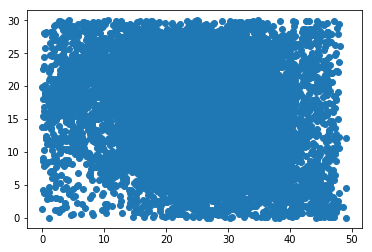

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./source_data/data.csv')

x0 = data['x_start']  # index = 2
y0 = data['y_start']  # index = 3

mask = [(x > 0) and (x < 50) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]
print("{}% of data inside this range".format(100*sum(mask)/len(mask)))
plt.scatter(x0[mask], y0[mask])
plt.show()



Taking this in mind we create the heatmap:


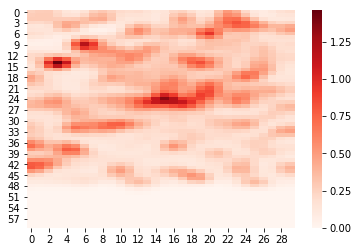

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2


# import data
data = pd.read_csv('./source_data/data.csv')
x0 = data['x_start']  # index = 2
y0 = data['y_start']  # index = 3
duration = data['duration']  # index = 7
mask = [(x > 0) and (x < 50) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]

# translate to a heatmap
heatmap = np.zeros((60, 30))
for x, y, t, valid in zip(x0, y0, duration, mask):
    if valid:
        heatmap[int(x), int(y)] = t

# gaussian filter heatmap
blurred_heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)

sb.heatmap(blurred_heatmap, cmap='Reds')
plt.show()



## Fixation/Saccade Characterization Overview

We calculate mean fixation duration and number as grand-average and per subject 
(bar + histogram) and also fixation per trial.


Grand average fixtime 0.9956280560552708[s]


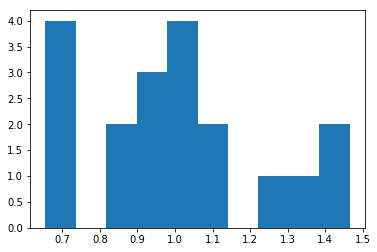

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
data = pd.read_csv('./source_data/data.csv')
duration = data['duration']
subject_mask = data['subject']
type_mask = data['type']

data_type = 3  # 1 = sacc, 2 = fix, 3 = sacc?
N = subject_mask.max()
mean_fixation_duration = np.empty(N)

for n in range(N):
    sub_fixations = [time for index, time in enumerate(duration) 
                     if subject_mask[index] == n+1 and type_mask[index] == data_type]
    mean_fixation_duration[n] = np.nanmean(sub_fixations)

print("Grand average fixtime {}[s]".format(np.nanmean(mean_fixation_duration)))
plt.hist(mean_fixation_duration)
plt.show()


## Cut acc signal according to trials frames (checkout if matlab was done right)


In [ ]:
# TODO: Make a function that cuts signal according to frames in trial, remember that acc signal is in time, 
# we need TTL = when acc was ON in frame
print("!")


## Calculate Performance Using MSE
We calculate performance MSE in 4 sensors (per subject, per trial, grand average)


In [ ]:
# TODO


## Calculate Gaze-time per zone


In [ ]:
# TODO

